## Cross Market Crypto Stat Arb

This is a statistical arbitrage strat that works generally as follows:

1. Create a sizeable basket of cointegrated pairs of (crypto token X, index fund with exposure to crypto token X)
2. Check each pair for deviations (intraday preferred, but might be better suited for daily trades to allow more time for reconvergence)
3. Generate trade signals based on deviations

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

Here we have a function that gets a dataframe of prices using yfinance. Not low frequency enough but still gets the general idea across.

In [23]:


def get_prices(tickers, start_date=None, end_date=None, join_type='inner'):
    if start_date is None:
        start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    price_data = []

    for ticker in tickers:
        try:
            df = yf.download(ticker, start=start_date, end=end_date)[['Close']]
            df.columns = [ticker]
            df = df.rename(columns={'Close': ticker})
            df.index = pd.to_datetime(df.index)
            price_data.append(df)
            print(f"Retrieved {ticker}: {len(df)} rows")
        except Exception as e:
            print(f"Error retrieving {ticker}: {e}")

    if not price_data:
        raise ValueError("No data retrieved.")


    combined = pd.concat(price_data, axis=1, join=join_type)
    combined.dropna(inplace=True)

    print(combined.head())

    return combined


transforms to log returns, tests for cointegration

In [ ]:
t1 = "ETH-USD"
t2 = "ETHV"  # Grayscale Ethereum Trust

data = get_prices([t1, t2])

log1 = np.log(data[t1])
log2 = np.log(data[t2])
print(len(log1),len(log2))

score, pvalue, _ = coint(log1, log2)

if pvalue < 0.05:
    print("The stocks are cointegrated.")
else:
    print("No cointegration detected.")


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Retrieved ETH-USD: 365 rows
Retrieved ETHV: 174 rows
                ETH-USD       ETHV
Date                              
2024-07-23  3481.995850  50.680000
2024-07-24  3336.339355  49.270000
2024-07-25  3174.427246  45.759998
2024-07-26  3275.951416  47.980000
2024-07-29  3320.539307  48.500000
174 174
The stocks are cointegrated.


plot residuals to find trade opportunities

Here we see that there are deviations which we can trade on.

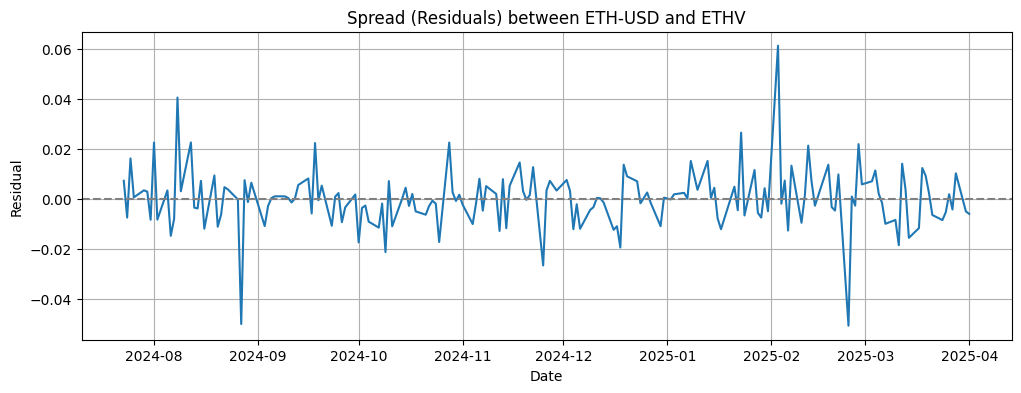

In [30]:
import statsmodels.api as sm

# Regress log1 on log2 to get residuals
X = sm.add_constant(log2)
model = sm.OLS(log1, X).fit()
residuals = model.resid

plt.figure(figsize=(12, 4))
plt.plot(residuals.index, residuals)
plt.title(f'Spread (Residuals) between {t1} and {t2}')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

same as above, just different scale and trading windows marked with red lines

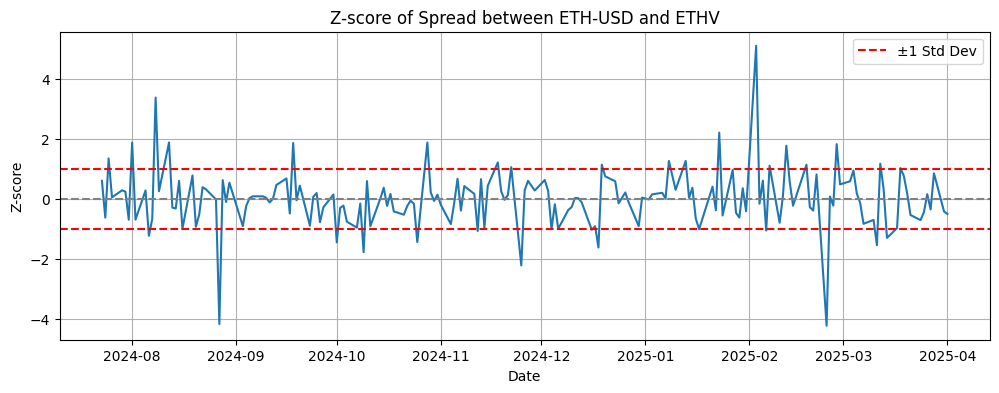

In [32]:
zscore = (residuals - residuals.mean()) / residuals.std()

plt.figure(figsize=(12, 4))
plt.plot(zscore.index, zscore)
plt.axhline(0, color='gray', linestyle='--')
plt.axhline(1, color='red', linestyle='--', label='±1 Std Dev')
plt.axhline(-1, color='red', linestyle='--')
plt.title(f'Z-score of Spread between {t1} and {t2}')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.show()